# Multichannel Timeseries

<img 
    src="./assets/240927_multichan.png" 
    alt="Multichannel Timeseries Workflow" 
    align="center" 
    style="border: 2px solid #ccc; border-radius: 8px; padding: 5px; width: 100%; box-shadow: 0px 4px 8px rgba(0,0,0,0.1);">


---

In [1]:
from IPython.display import HTML
HTML("""
<div style="display: flex; justify-content: center; padding: 10px;">
    <iframe width="560" height="315" src="https://www.youtube.com/embed/8oeuPptWPt8?si=yh-4iJYDfYpJZ7MQ" title="YouTube video player" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>
</div>
""")

---

## Prerequisites

| What? | Why? |
| --- | --- |
| [Index: Intro, Workflows, Extensions](./index.ipynb) | For context and workflow selection/feature guidance |

## Overview

For an introduction, please visit the ['Index'](./index.ipynb) page. This workflow is tailored for processing and analyzing 'medium-sized' multichannel timeseries data derived from [electrophysiological](https://en.wikipedia.org/wiki/Electrophysiology) recordings. 

### What Defines a 'Medium-Sized' Dataset?

In this context, we'll define a medium-sized dataset as that which is challenging for browsers (roughly more than 100,000 samples) but can be handled within the available RAM without exhausting system resources.

### Why Downsample?

Medium-sized datasets can strain the processing capabilities when visualizing or analyzing data directly in the browser. To address this challenge, we will employ a smart-downsampling approach - reducing the dataset size by selectively subsampling the data points. Specifically, we'll make use of a variant of a downsampling algorithm called [Largest Triangle Three Buckets (LTTB)](https://skemman.is/handle/1946/15343). LTTB allows data points not contributing significantly to the visible shape to be dropped, reducing the amount of data to send to the browser but preserving the appearance (and particularly the envelope, i.e. highest and lowest values in a region). This ensures efficient data handling and visualization without significant loss of information.

Downsampling is particularly beneficial when dealing with numerous timeseries sharing a common time index, as it allows for a consolidated slicing operation across all series, significantly reducing the computational load and enhancing responsiveness for interactive visualization. We'll make use of a [Pandas](https://pandas.pydata.org/docs/index.html) index to represent the time index across all timeseries.

### Quick Introduction to MNE

[MNE (MNE-Python)](https://mne.tools/stable/index.html) is a powerful open-source Python library designed for handling and analyzing data like EEG and MEG. In this workflow, we'll utilize an EEG dataset, so we demonstrate how to use MNE for loading, preprocessing, and conversion to a Pandas DataFrame. However, the data visualization section is highly generalizable to dataset types beyond the scope of MNE, so you can meet us there if you have your timeseries data as a Pandas DataFrame with a time index and channel columns.


---

## Imports and Configuration

In [2]:
from pathlib import Path

import holoviews as hv
import mne
import pandas as pd
import panel as pn
import pooch
from holoviews.operation.downsample import downsample1d

pn.extension('tabulator')
hv.extension('bokeh')

## Loading and Inspecting the Data

Let's get some data! This section walks through obtaining an EEG dataset (2.6 MB).

In [3]:
DATA_URL = 'https://datasets.holoviz.org/eeg/v1/S001R04.edf'
DATA_DIR = Path('./data')
DATA_FILENAME = Path(DATA_URL).name
DATA_PATH = DATA_DIR / DATA_FILENAME

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Note</p>
    If you are viewing this notebook as a result of using the `anaconda-project run` command, the data has already been ingested, as configured in the associated yaml file. Running the following cell should find that data and skip any further download.
</div>

In [4]:
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Download the data if it doesn't exist
if not DATA_PATH.exists():
    print(f'Downloading data to: {DATA_PATH}')
    pooch.retrieve(
        url=DATA_URL,
        known_hash=None,
        fname=DATA_FILENAME,
        path=DATA_DIR,
        progressbar=True,
    )
else:
    print(f'Data exists at: {DATA_PATH}')

Data exists at: data/S001R04.edf


Once we have a local copy of the data, the next crucial step is to load it into an analysis-friendly format and inspect its basic characteristics:

In [5]:
raw = mne.io.read_raw_edf(DATA_PATH, preload=True)
print('num samples in dataset:', len(raw.times) * len(raw.ch_names))
raw.info

Extracting EDF parameters from /home/runner/work/examples/examples/multichannel_timeseries/data/S001R04.edf...


EDF file detected


Setting channel info structure...


Creating raw.info structure...


Reading 0 ... 19999  =      0.000 ...   124.994 secs...


num samples in dataset: 1280000


<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>

This step confirms the successful loading of the data and provides an initial understanding of its structure, such as the number of channels and samples.

Now, let's preview the channel names, types, unit, and signal ranges. This `describe` method is from MNE, and we can have it return a Pandas DataFrame, from which we can `sample` some rows.

In [6]:
raw.describe(data_frame=True).sample(5)

,name,type,unit,min,Q1,median,Q3,max
ch,,,,,,,,
42,T9..,eeg,V,-0.000161,-0.000033,-0.000002,0.000029,0.000206
6,Fc6.,eeg,V,-0.000159,-0.000026,0.000001,0.000027,0.000176
14,Cp5.,eeg,V,-0.000191,-0.000034,-0.000002,0.000031,0.000192
29,F7..,eeg,V,-0.000323,-0.000041,-0.000003,0.000037,0.000331
19,Cp4.,eeg,V,-0.000186,-0.000034,-0.000002,0.000029,0.000180


## Pre-processing the Data


### Noise Reduction via Averaging

Significant noise reduction is often achieved by employing an average reference, which involves calculating the mean signal across all channels at each time point and subtracting it from the individual channel signals:

In [7]:
raw.set_eeg_reference("average")

EEG channel type selected for re-referencing


Applying average reference.


Applying a custom ('EEG',) reference.


<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

### Standardizing Channel Names

From the output of the `describe` method, it looks like the channels are from commonly used standardized locations (e.g. 'Cz'), but contain some unnecessary periods, so let's clean those up to ensure smoother processing and analysis.

In [8]:
raw.rename_channels(lambda s: s.strip("."));

### Optional: Enhancing Channel Metadata

Visualizing physical locations of EEG channels enhances interpretative analysis. MNE has functionality to assign locations of the channels based on their standardized channel names, so we can go ahead and assign a commonly used arrangement (or 'montage') of electrodes ('10-05') to this data. Read more about making and setting the montage [here](https://mne.tools/stable/auto_tutorials/intro/40_sensor_locations.html#sphx-glr-auto-tutorials-intro-40-sensor-locations-py).

In [9]:
montage = mne.channels.make_standard_montage("standard_1005")
raw.set_montage(montage, match_case=False)

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MB, data loaded>

We can see that the 'digitized points' (locations) are now added to the raw data.

Now let's plot the channels using MNE [`plot_sensors`](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.plot_sensors) on a top-down view of a head. Note, we'll tweak the reference point so that all the points are contained within the depiction of the head.

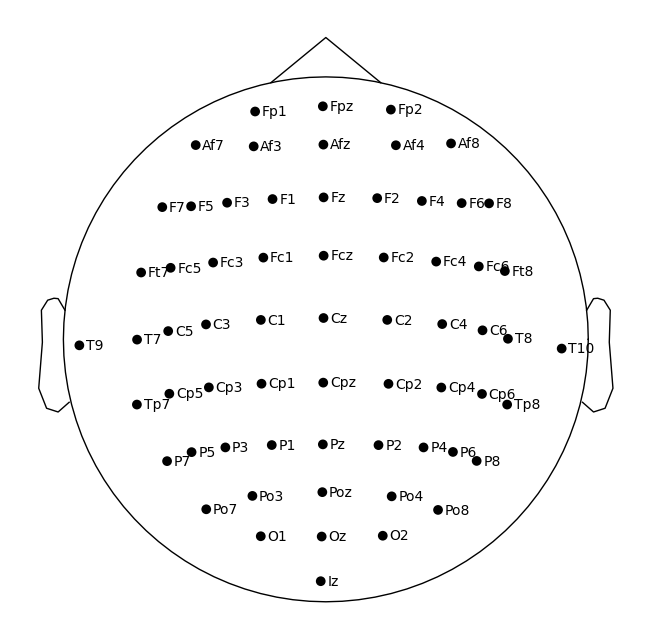

In [10]:
sphere=(0, 0.015, 0, 0.099) # manually adjust the y origin coordinate and radius
raw.plot_sensors(show_names=True, sphere=sphere, show=False);

## Data Visualization

### Preparing Data for Visualization

We'll use an MNE method, `to_data_frame`, to create a Pandas DataFrame. By default, MNE will convert EEG data from Volts to microVolts (µV) during this operation.

In [11]:
df = raw.to_data_frame()
df.set_index('time', inplace=True) 
df.head()

,Fc5,Fc3,Fc1,Fcz,Fc2,Fc4,Fc6,C5,C3,C1,...,P8,Po7,Po3,Poz,Po4,Po8,O1,Oz,O2,Iz
time,,,,,,,,,,,,,,,,,,,,,
0.00000,8.703125,15.703125,50.703125,52.703125,43.703125,39.703125,-2.296875,-0.296875,17.703125,31.703125,...,-7.296875,5.703125,-21.296875,-31.296875,-52.296875,-25.296875,-19.296875,-34.296875,-25.296875,-25.296875
0.00625,46.062500,34.062500,59.062500,56.062500,43.062500,36.062500,3.062500,22.062500,31.062500,33.062500,...,8.062500,18.062500,-9.937500,-6.937500,-25.937500,6.062500,37.062500,16.062500,27.062500,24.062500
0.01250,-13.656250,-14.656250,4.343750,-1.656250,0.343750,8.343750,-3.656250,-24.656250,-7.656250,-1.656250,...,46.343750,41.343750,13.343750,28.343750,15.343750,45.343750,43.343750,21.343750,34.343750,36.343750
0.01875,-3.015625,-4.015625,12.984375,-2.015625,2.984375,7.984375,-5.015625,0.984375,9.984375,8.984375,...,23.984375,2.984375,-15.015625,-1.015625,-5.015625,21.984375,18.984375,0.984375,28.984375,19.984375
0.02500,20.656250,10.656250,32.656250,12.656250,11.656250,2.656250,-17.343750,13.656250,15.656250,12.656250,...,21.656250,10.656250,-4.343750,11.656250,2.656250,28.656250,5.656250,-4.343750,31.656250,20.656250


### Creating the Multichannel Timeseries Plot

As of the time of writing, there's no easy way to track units with Pandas, so we can use a modular HoloViews approach to create and annotate dimensions with a unit, and then refer to these dimensions when plotting. Read more about annotating data with HoloViews [here](https://holoviews.org/user_guide/Annotating_Data.html).

In [12]:
time_dim = hv.Dimension("time", unit="s") # match the df index name, 'time'

Now we will loop over the columns (channels) in the dataframe, creating a HoloViews `Curve` element from each. Since each column in the df has a different channel name, which is generally not describing a measurable quantity, we will map from the channel to a common `amplitude` dimension (see [this issue](https://github.com/holoviz/holoviews/issues/6260) for details of this enhancement for 'wide' tabular data), and collect each `Curve` element into a Python dictionary.

In configuring these curves, we apply the `.opts` method from HoloViews to fine-tune the visualization properties of each curve. The `subcoordinate_y` setting is pivotal for managing time-aligned, amplitude-diverse plots. When enabled, it arranges each curve along its own segment of the y-axis within a single composite plot. This method not only aids in differentiating the data visually but also in analyzing comparative trends across multiple channels, ensuring that each channel's data is individually accessible and comparably presentable, thereby enhancing the analytical value of the visualizations. Applying `subcoordinate_y` has additional effects, such as creating a Y-axis zoom tool that applies to individual subcoordinate axes rather than the global Y-axis. Read more about `subcoordinate_y` [here](https://holoviews.org/user_guide/Customizing_Plots.html#subcoordinate-y-axis).

In [13]:
curves = {}
for col in df.columns:
    col_amplitude_dim = hv.Dimension(col, label='amplitude', unit="µV") # map amplitude-labeled dim per chan
    curves[col] = hv.Curve(df, time_dim, col_amplitude_dim, group='EEG', label=col)
    # Apply options
    curves[col] = curves[col].opts(
        subcoordinate_y=True, # Essential to create vertically stacked plot
        subcoordinate_scale=3,
        color="black",
        line_width=1,
        hover_tooltips = [
            ("type", "$group"),
            ("channel", "$label"),
            ("time"),
            ("amplitude")],
        tools=['xwheel_zoom'],
        active_tools=["box_zoom"]
    )

Using a HoloViews container, we can now overlay all the curves on the same plot.

In [14]:
curves_overlay = hv.Overlay(curves, kdims=[time_dim, 'Channel'])

overlay_opts = dict(ylabel="Channel",
    show_legend=False,
    padding=0,
    min_height=600,
    responsive=True,
    title="",
)

curves_overlay = curves_overlay.opts(**overlay_opts)

### Apply Downsampling

Since there are dozens of channels and over a million data samples, we'll make use of downsampling before trying to send all that data to the browser. We can use `downsample1d` imported from HoloViews. Starting in HoloViews version 1.19.0, integration with the `tsdownsample` library introduces enhanced downsampling algorithms. Read more about downsampling [here](https://holoviews.org/user_guide/Large_Data.html).

In [15]:
curves_overlay_lttb = downsample1d(curves_overlay, algorithm='minmax-lttb')

### Display Multichannel Timeseries Plot

It is recommended to only have a single rendered instance of the same application component in a notebook, so we've commented out the following cell so we can demonstrate additional extensions below. But feel free to uncomment and display the following if you don't want any further extensions.

In [16]:
# curves_overlay_lttb

<img 
    src="./assets/multichan_no-extensions.png" 
    alt="Static Preview No Extensions" 
    align="right" 
    width="70%">

**Here's a static snapshot of what the previous cell produces (a DynamicMap of downsampled and overlaid curve subplots). 👉**

<div style="clear: both;"></div>

In [17]:
print(curves_overlay_lttb)

:DynamicMap   []


---
---

## Minimap Extension

To assist in navigating the dataset, we integrate a minimap widget. This secondary minimap plot provides a condensed overview of the entire dataset, allowing users to select and zoom into areas of interest quickly in the main plot while maintaining the contextualization of the zoomed out view.

We will employ datashader rasterization of the image for the minimap plot to display a browser-friendly, aggregated view of the entire dataset. Read more about datashder rasterization via HoloViews [here](https://holoviews.org/user_guide/Large_Data.html).

In [18]:
from scipy.stats import zscore
from holoviews.operation.datashader import rasterize
from holoviews.plotting.links import RangeToolLink

channels = df.columns
time = df.index.values

y_positions = range(len(channels))
yticks = [(i, ich) for i, ich in enumerate(channels)]
z_data = zscore(df, axis=0).T
minimap = rasterize(hv.Image((time, y_positions, z_data), [time_dim, "Channel"], "amplitude"))

minimap_opts = dict(
    cmap="RdBu_r",
    colorbar=False,
    xlabel='',
    alpha=0.5,
    yticks=[yticks[0], yticks[-1]],
    toolbar='disable',
    height=120,
    responsive=True,
    cnorm='eq_hist',
    )

minimap = minimap.opts(**minimap_opts)

The connection between the main plot and the minimap is facilitated by a `RangeToolLink`, enhancing user interaction by synchronizing the visible range of the main plot with selections made on the minimap. Optionally, we'll also constrain the initially displayed x-range view to a third of the duration.

In [19]:
RangeToolLink(minimap, curves_overlay_lttb, axes=["x", "y"],
              boundsx=(0, time[len(time)//3]), # limit the initial selected x-range of the minimap
              boundsy=(-.5,len(channels)//3), # limit the initial selected y-range of the minimap
              use_handles=False, # Optionally, disable handles on the RangeTool box selection
             )

RangeToolLink(axes=['x', 'y'], boundsx=(0, np.float64(41.6625)), boundsy=(-0.5, 21), intervalsx=None, intervalsy=None, inverted=True, name='RangeToolLink00869', start_gesture='tap', use_handles=False)

Finally, we'll arrange the main plot and minimap into a single column layout.

In [20]:
app = (curves_overlay_lttb + minimap).opts(shared_axes=False).cols(1)

It is recommended to only have a single rendered instance of the same application component in a notebook, so we've commented out the following cell so we can demonstrate additional extensions below. But feel free to uncomment and display the following if you don't want any further extensions.

In [21]:
# app

<img 
    src="./assets/multichan_minimap.png" 
    alt="Static Preview Minimap" 
    align="right" 
    width="70%">

**Here's a static snapshot of what the previous cell produces (a layout of two DynamicMap elements - the downsampled curves plot and a rasterized minimap plot). 👉**

<div style="clear: both;"></div>


In [22]:
# print(app)

## Scale Bar Extension

While the hover tooltips in our plot allow us to inspect amplitude values at specific points, sometimes it's beneficial to have a persistent visual reference for amplitude measurements. Adding a scale bar provides a constant guide to the amplitude scale, enhancing the interpretability of our visualization, especially when comparing signal amplitudes across different channels or time windows.

In HoloViews, we can incorporate a [scale bar](https://holoviews.org/reference/features/bokeh/Scalebar.html) into any curve element. This feature displays a bar that represents a specific amplitude value, which can be toggled on or off using the measurement ruler icon in the plot's toolbar. This allows users to choose whether they want the scale bar visible.

For our application, we'll add a scale bar to one of the EEG channels—specifically, channel `'C1'`. We'll customize the scale bar's appearance and behavior using `.opts`, ensuring it aligns with the units of our data (microvolts, µV). The `scalebar_opts` dictionary allows us to fine-tune the visual aspects of the scale bar, such as line width, label location, background color, and whether the scale bar size adapts when zooming. See more options in the [Bokeh docs](https://docs.bokeh.org/en/latest/docs/reference/models/annotations.html#bokeh.models.ScaleBar).

In [23]:

curves['C1'].opts(
        scalebar=True,
        scalebar_location="right",
        scalebar_unit=('µV', 'V'),
        scalebar_opts={
            'bar_line_width':3,
            'label_location':'left',
            'background_fill_color':'white',
            'background_fill_alpha':.6,
            'length_sizing':'adaptive',
            'bar_length_units': 'data',
            'bar_length':.8,
        }
); # add semicolon to prevent display of output

Uncomment and display the following if you don't want any further extensions.

In [24]:
app

:Layout
   .DynamicMap.I  :DynamicMap   []
      :Overlay
         .EEG.Fc5 :Curve   [time]   (amplitude)
         .EEG.Fc3 :Curve   [time]   (amplitude)
         .EEG.Fc1 :Curve   [time]   (amplitude)
         .EEG.Fcz :Curve   [time]   (amplitude)
         .EEG.Fc2 :Curve   [time]   (amplitude)
         .EEG.Fc4 :Curve   [time]   (amplitude)
         .EEG.Fc6 :Curve   [time]   (amplitude)
         .EEG.C5  :Curve   [time]   (amplitude)
         .EEG.C3  :Curve   [time]   (amplitude)
         .EEG.C1  :Curve   [time]   (amplitude)
         .EEG.Cz  :Curve   [time]   (amplitude)
         .EEG.C2  :Curve   [time]   (amplitude)
         .EEG.C4  :Curve   [time]   (amplitude)
         .EEG.C6  :Curve   [time]   (amplitude)
         .EEG.Cp5 :Curve   [time]   (amplitude)
         .EEG.Cp3 :Curve   [time]   (amplitude)
         .EEG.Cp1 :Curve   [time]   (amplitude)
         .EEG.Cpz :Curve   [time]   (amplitude)
         .EEG.Cp2 :Curve   [time]   (amplitude)
         .EEG.Cp4 :Curve   [time]   (amplitude)
         .EEG.Cp6 :Curve   [time]   (amplitude)
         .EEG.Fp1 :Curve   [time]   (amplitude)
         .EEG.Fpz :Curve   [time]   (amplitude)
         .EEG.Fp2 :Curve   [time]   (amplitude)
         .EEG.Af7 :Curve   [time]   (amplitude)
         .EEG.Af3 :Curve   [time]   (amplitude)
         .EEG.Afz :Curve   [time]   (amplitude)
         .EEG.Af4 :Curve   [time]   (amplitude)
         .EEG.Af8 :Curve   [time]   (amplitude)
         .EEG.F7  :Curve   [time]   (amplitude)
         .EEG.F5  :Curve   [time]   (amplitude)
         .EEG.F3  :Curve   [time]   (amplitude)
         .EEG.F1  :Curve   [time]   (amplitude)
         .EEG.Fz  :Curve   [time]   (amplitude)
         .EEG.F2  :Curve   [time]   (amplitude)
         .EEG.F4  :Curve   [time]   (amplitude)
         .EEG.F6  :Curve   [time]   (amplitude)
         .EEG.F8  :Curve   [time]   (amplitude)
         .EEG.Ft7 :Curve   [time]   (amplitude)
         .EEG.Ft8 :Curve   [time]   (amplitude)
         .EEG.T7  :Curve   [time]   (amplitude)
         .EEG.T8  :Curve   [time]   (amplitude)
         .EEG.T9  :Curve   [time]   (amplitude)
         .EEG.T10 :Curve   [time]   (amplitude)
         .EEG.Tp7 :Curve   [time]   (amplitude)
         .EEG.Tp8 :Curve   [time]   (amplitude)
         .EEG.P7  :Curve   [time]   (amplitude)
         .EEG.P5  :Curve   [time]   (amplitude)
         .EEG.P3  :Curve   [time]   (amplitude)
         .EEG.P1  :Curve   [time]   (amplitude)
         .EEG.Pz  :Curve   [time]   (amplitude)
         .EEG.P2  :Curve   [time]   (amplitude)
         .EEG.P4  :Curve   [time]   (amplitude)
         .EEG.P6  :Curve   [time]   (amplitude)
         .EEG.P8  :Curve   [time]   (amplitude)
         .EEG.Po7 :Curve   [time]   (amplitude)
         .EEG.Po3 :Curve   [time]   (amplitude)
         .EEG.Poz :Curve   [time]   (amplitude)
         .EEG.Po4 :Curve   [time]   (amplitude)
         .EEG.Po8 :Curve   [time]   (amplitude)
         .EEG.O1  :Curve   [time]   (amplitude)
         .EEG.Oz  :Curve   [time]   (amplitude)
         .EEG.O2  :Curve   [time]   (amplitude)
         .EEG.Iz  :Curve   [time]   (amplitude)
   .DynamicMap.II :DynamicMap   []
      :Image   [time,Channel]   (amplitude)


<img 
    src="./assets/multichan_scalebar.png" 
    alt="Static Preview Scalebar" 
    align="right" 
    width="70%">

**Here's a static snapshot of what the previous cell produces (the previous layout with the addition of a scalebar for one of the curves). 👉**


The pink arrow annotation indicates the newly added adaptive scale bar, and the green arrow points to the toolbar icon used to toggle its display.


<div style="clear: both;"></div>

In [25]:
# print(app)

As you interact with the plot by zooming in and out, you'll notice that the scale bar adapts to the current zoom level. This dynamic adjustment ensures that the scale bar remains a relevant reference regardless of the level of detail you're viewing.

## Time Range Annotation Extension

In this extension, we'll enhance our multichannel timeseries visualization by adding interactive time range annotations. This feature allows us to mark and label specific periods within the data, which can be invaluable for highlighting events, artifacts, or regions of interest during analysis.

We'll utilize the [HoloNote](https://holonote.holoviz.org/) package, which extends HoloViews with tools for annotating plots and integrating them into interactive dashboards.

### Preparing Annotations Data
If you don't have any preexisting annotations, that's perfectly fine. You can proceed without an initial DataFrame and use HoloNote to create annotations from scratch interactively within your visualization. In this case, you can initialize an empty DataFrame or skip the DataFrame preparation step.

However, if you do have preexisting annotations, either from a separate file or embedded in the dataset, read them into a Pandas DataFrame as we do below and adjust the code accordingly to fit your data structure. We'll demonstrate how to extract annotations that are embedded in our EEG demo dataset (See [men.Annotations](https://mne.tools/stable/generated/mne.Annotations.html) for information on handling these annotations):

In [26]:
if any(raw.annotations):
    # Get the initial time of the experiment
    orig_time = raw.annotations.orig_time
    
    # Convert the annotations to a DataFrame
    annotations_df = raw.annotations.to_data_frame()
    
    # Ensure the 'onset' column is in UTC timezone
    annotations_df['onset'] = annotations_df['onset'].dt.tz_localize('UTC')
    
    # Create 'start' and 'end' columns in seconds relative to the experiment start
    annotations_df['start'] = (annotations_df['onset'] - orig_time).dt.total_seconds()
    annotations_df['end'] = annotations_df['start'] + annotations_df['duration']
    
    # Preview the annotations DataFrame
    annotations_df.head()
else:
    # If no annotations are included in our dataset, initialize with an empty data
    annotations_df = pd.DataFrame(columns=['start', 'end'])

### Setting Up the Annotator

Now we'll configure the Annotator object from HoloNote, which manages the annotations and integrates them with our plots.

In this demo, we're using a `connector` to an in-memory SQLite database by specifying `SQLiteDB(filename=':memory:')` for temporary storage of annotations:

In [27]:
from holonote.annotate import Annotator
from holonote.app import PanelWidgets, AnnotatorTable
from holonote.annotate.connector import SQLiteDB

annotator = Annotator(
    {'time': float}, # Indicates that we are working with time-based annotations
    fields=["description"],
    groupby = "description", # Group annotations to enable color-coding and batch actions
    connector=SQLiteDB(filename=':memory:'),
)

**Note on Persistent Storage:** If we don't specify a connector, HoloNote will by default create a persistent SQLite database file named 'annotations.db' in the current directory. You can also specify a custom filename in place of `':memory:'` to store annotations persistently in a specific file, such as `SQLiteDB(filename='my_annotations.db')`.

When working in a real workflow, you'll likely want persistent storage to save your annotations between sessions. Be aware that if a file with the specified name already exists, HoloNote will use it, and any changes committed through the UI will modify this file. This allows you to maintain and update your annotations across different sessions, ensuring your work is saved and accessible later.

### Defining Annotations

We now populate the Annotator with the annotations from our DataFrame. If you have an existing `annotations_df`, whether extracted from the dataset or loaded from a file, you can define the annotations as follows:

In [28]:
annotator.define_annotations(annotations_df, time=("start", "end"))

This line tells the annotator to use the 'start' and 'end' columns from our DataFrame as the time ranges for the annotations.

If you started without any existing annotations, you can skip this step, and the Annotator will start without any annotations, ready for you to add new ones interactively.

### Configuring Annotation Widgets
To enable interaction with the annotations, we'll create widgets that allow users to view and manage them.

In [29]:
annotator.visible = ["T1", "T2"]  # Optional, specify which to initially display

annotator_widgets = pn.WidgetBox(
    PanelWidgets(annotator),
    AnnotatorTable(
        annotator,
        tabulator_kwargs=dict(
            pagination="local",
            page_size=10,
            sizing_mode="stretch_both",
            layout="fit_columns",
            theme="default",
            stylesheets=[":host .tabulator {font-size: 12px;}"],
            text_align={"description": "center"},
        ),
    ),
    max_width=325,
)

The above code creates a `WidgetBox` containing:
- Annotation controls (PanelWidgets) for adding, editing, or deleting annotations. Since we grouped the annotations, `PanelWidgets` will also include a 'Visible' widget to toggle visibility by group.
- An `AnnotatorTable` to display annotations in a tabular format.

We also customize the table's appearance and functionality using `tabulator_kwargs`, adjusting pagination, sizing, layout, theme, style, and text alignment. Check our the [Panel Tabulator](https://panel.holoviz.org/reference/widgets/Tabulator.html) docs for more options.

### Integrating Annotations with the Plots

Finally, we'll overlay the annotations onto our existing multichannel timeseries plot and the minimap. This integration allows us to see the annotations directly on the plots and interact with them.

Add new annotations by:
- Ensure that the '+' button is selected in the widgets.
- Ensure that 'Box select (x-axis)' is selected in the Bokeh Toolbar.
- Enter the name of the group that you want the annotation to be added to in the 'description' text box.
- Select a time range by clicking and dragging on the plot
- Edit or delete annotations using the provided widgets and table.

Note, if you are using a persistent file on disk for the annotations, hit the triangle button to commit changes to the file.

In [30]:
annotated_multichan = (annotator * curves_overlay_lttb).opts(responsive=True, min_height=700)
annotated_minimap = (annotator * minimap)
annotated_app = (annotated_multichan + annotated_minimap).cols(1).opts(shared_axes=False)

<div class="admonition alert alert-info">
    <p style="font-weight:bold; font-size: 16px;">⚠️ Heads up!</p>
    <p>Viewing this on <code>examples.holoviz.org</code>? This is a static version of the notebook 📄. Interactive features that require a live Python process, like downsampling and datashading, won’t work here 🚫. To use these features, open the notebook with a live Python session.</p>
</div>


In [31]:
pn.Row(annotator_widgets, annotated_app)

Row
    [0] WidgetBox(max_width=325)
        [0] Column
            [0] MultiSelect(name='Visible', options=['T0', 'T1', 'T2'], stylesheets=['\n        option {...], value=['T1', 'T2'])
            [1] Column
                [0] TextInput(name='description', placeholder='description')
            [2] Row
                [0] Button(description=Tooltip(id='a5b9408a-060e-..., name='✓', width=20)
                [1] Spacer(width=10)
                [2] RadioButtonGroup(description=Tooltip(id='94691a0d-1b41-..., name='Mode', options=['+', '-', '✏'], value='+', width=90)
                [3] Spacer(width=10)
                [4] Button(description=Tooltip(id='6903007b-f3cc-..., name='↺', width=20)
                [5] Button(description=Tooltip(id='46893134-f9c0-..., name='▲', width=20)
        [1] Tabulator(buttons={'delete': '<i c...}, layout='fit_columns', page_size=10, pagination='local', show_index=False, sizing_mode='stretch_both', stylesheets=[':host .tabulator {...], text_align={'description': 'center'}, theme='default', value=              ...)
    [1] HoloViews(Layout, sizing_mode='stretch_both')

## Standalone App Extension

HoloViz Panel allows for the deployment of this complex visualization as a standalone, template-styled, interactive web application (outside of a Jupyter Notebook). Read more about Panel [here](https://panel.holoviz.org/).

We'll add our plots to the `main` area of a Panel Template component and the widgets to the `sidebar`. Finally, we'll set the entire component to be `servable`.

To launch the standalone app, activate the same conda environment and run `panel serve <path-to-this-file> --show` in the command line. This will open the application in a browser window.

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    It is not recommended to have both a notebook version of the application and a served of the same application running simultaneously. Prior to serving the standalone application, clear the notebook output, restart the notebook kernel, and saved the unexecuted notebook file.
</div>

In [32]:
servable_app = pn.template.FastListTemplate(
    sidebar = annotator_widgets,
    title = "HoloViz + Bokeh Multichannel Timeseries with Time-Range Annotator",
    main = annotated_app,
).servable()


<img  
    src="./assets/multichan_standalone.png" 
    alt="Static Preview Multichan Standalone" 
    align="right" 
    width="70%">

**Here's a static snapshot of what the previous cell produces in a browser window when you serve the standalone app (a templated Panel application). 👉**

<div style="clear: both;"></div>

In [33]:
print(servable_app)

<FastListTemplate FastListTemplate06491>


## What Next?
- Head back to the [Index](./index.ipynb) page to explore other workflow alternatives, such as [Large Multichannel Timeseries](1_large_multichan.ipynb).

## Related Resources

| What? | Why? |
| --- | --- |
| [MNE Docs](https://mne.tools/stable/index.html) | Learn how to process and analyze EEG/MEG |